# Домашнее задание №1 - Метод К-ближайших соседей (K-neariest neighbors)

Сегодня мы с вами реализуем наш первый алгоритм машинного обучения, метод К-ближайших соседей. Мы попытаемся решить с помощью него задачи:
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)
- регрессии (когда зависимая переменная - натуральное число)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, то нам нужно научиться подбирать этот параметр. Мы постараемся научиться пользовать numpy для векторизованных вычислений, а также посмотрим на несколько метрик, которые используются в задачах классификации и регрессии.

Перед выполнением задания:
- установите все необходимые библиотеки, запустив `pip install -r requirements.txt`

Если вы раньше не работали с numpy или позабыли его, то можно вспомнить здесь:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import sys
#!{sys.executable} -m pip install seaborn_image

In [2]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
import numpy as np
import random
import pandas as pd
import Bio

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from knn import KNNClassifier
from metrics import binary_classification_metrics, multiclass_accuracy

In [3]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

## Задание 1. KNN на датасете Fashion-MNIST (10 баллов)

В этом задании вам предстоит поработать с картинками одежды, среди которых можно выделить 10 классов. Данные уже загружены за вас: в переменной X лежат 70000 картинок размером 28 на 28 пикселей, вытянутые в вектор размерностью 784 (28 * 28). Так как данных довольно много, а наш KNN будет весьма медленный, то возьмем случайно 1000 наблюдений (в реальности в зависимости от вашей реализации можно будет взять больше, но если будет не зватать ОЗУ, то берите меньше).

In [4]:
X, y = fetch_openml(name="Fashion-MNIST", return_X_y=True, as_frame=False)

In [5]:
idx_to_stay = np.random.choice(np.arange(X.shape[0]), replace=False, size=1000)
X = X[idx_to_stay]
y = y[idx_to_stay]

Давайте посмотрим на какое-нибудь изображение из наших данных:

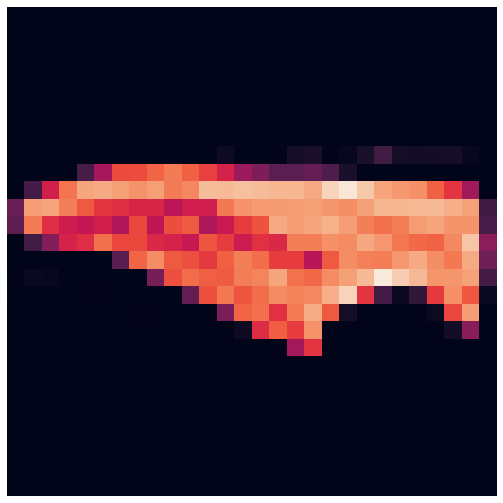

In [6]:
# возьмем случайную картинку и сделаем reshape
# 28, 28, 1 = H, W, C (число каналов, в данном случае 1)
image = X[np.random.choice(np.arange(X.shape[0]))].reshape(28, 28, 1)
plt.imshow(image)
plt.axis("off");

### 1.1. Посмотрим на все классы (0.5 баллов)

Возьмите по одной картинке каждого класса и изобразите их (например, сделайте subplots 5 на 2).

(0.0, 1.0, 0.0, 1.0)

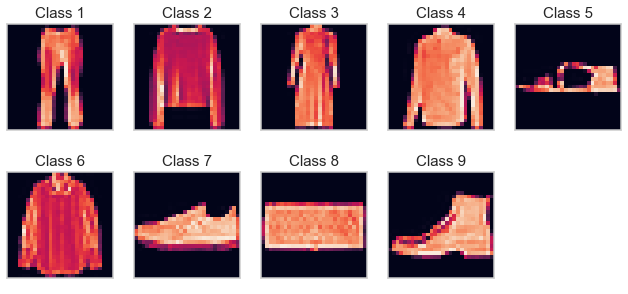

In [7]:
f, axes = plt.subplots(figsize=(11,5), nrows=2, ncols=5)

# take the first picture from each class
classes = [i for i in range(1,10)]
for class_code in classes: 
    for n in range (len (y)):
        if int(y[n]) == class_code:
            image = X[n].reshape(28, 28, 1)
            axes_number = axes[(class_code-1)//5,(class_code-1)%5]
            isns.imgplot(image, ax=axes_number)
            axes_number.set_title(f"Class {class_code}")
            axes_number.invert_yaxis()
            break
            
# if you don't turn off the axis, the last empty plot will have axes, so it will look ugly
plt.axis("off")

### 1.2. Сделайте небольшой EDA (1 балл)

Посмотрите на баланс классов. В дальнейших домашках делайте EDA, когда считаете нужным, он нужен почти всегда, но оцениваться это уже не будет, если не будет указано иное. Делайте EDA, чтобы узнать что-то новое о данных!

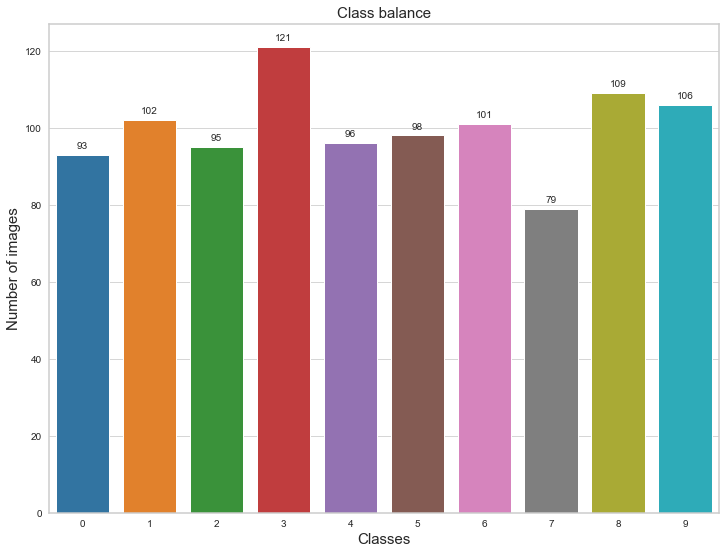

In [8]:
# getting counts of unique values in our class column
(unique, counts) = np.unique(y, return_counts=True)
frequencies = np.asarray((unique, counts)).T

# plotting the classes and their counts
ax = sns.barplot(x = frequencies [:, 0], y = frequencies [:, 1])
ax.set_title("Class balance")
ax.set(xlabel='Classes', ylabel='Number of images')

# the next piece is taken from 
# https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values to annotate values on the barchart
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

So the classes are more or less uqually represented, Class 3 being the most popular class with 121 occurencies and Class 7 - the least popular one with 79 occurencies.


### 1.3. Разделите данные на train и test (0.5 баллов)

Разделите данные на тренировочную и тестовую выборки, размеры тестовой выборки выберите сами. Здесь вам может помочь функция `train_test_split`

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

### 1.4. KNN для бинарной классификации (6 баллов)

Давайте возьмем для задачи бинарной классификации только объекты с метками классов 0 и 1.

In [10]:
bool_train01 = ((y_train == '0') | (y_train == '1'))
bool_test01 = ((y_test == '0') | (y_test == '1'))
x_train01 = x_train[bool_train01]
y_train01 = y_train[bool_train01]
x_test01 = x_test[bool_test01]
y_test01 = y_test[bool_test01]

И вот мы подготовили данные, но модели у нас пока что нет. В нескольких занятиях нашего курса вам придется самостоятельно реализовывать какие-то алгоритмы машинного обучения, а потом сравнивать их с готовыми библиотечными решениями. В остальных заданиях реализовывать алгоритмы будет не обязательно, но может быть полезно, поэтому часто это будут задания на дополнительные баллы, но главное не это, а понимание работы алгоритма после его реализации с нуля на простом numpy. Также это все потом можно оформить в виде репозитория ml_from_scratch и хвастаться перед друзьями.

In [11]:
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(x_train01, y_train01)

### Настало время писать код!

В KNN нам нужно для каждого тестового примера найти расстояния до всех точек обучающей выборки. Допустим у нас 1000 примеров в train'е и 100 в test'е, тогда в итоге мы бы хотели получить матрицу попарных расстояний (например, размерностью 100 на 1000). Это можно сделать несколькими способами, и кому-то наверняка, в голову приходит идея с двумя вложенными циклами (надеюсь, что не больше:). Так можно делать, но можно и эффективнее. Вообще, в реальном KNN используется структура данных [k-d-tree](https://ru.wikipedia.org/wiki/K-d-%D0%B4%D0%B5%D1%80%D0%B5%D0%B2%D0%BE), которая позволяет производить поиск за log(N), а не за N, как будем делать мы (по сути это такое расширение бинарного поиска на многомерное пространство).

Вам нужно будет последовательно реализовать методы `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops` класса `KNN` в файле `knn.py`.

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание** Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)).

$d_{1}(\mathbf {p} ,\mathbf {q} )=\|\mathbf {p} -\mathbf {q} \|_{1}=\sum _{i=1}^{n}|p_{i}-q_{i}|$

В начале я буду иногда писать разные assert'ы, чтобы можно было проверить правильность реализации, в дальнейшем вам нужно будет их писать самим, если нужно будет проверять корректность каких-то вычислений.

In [12]:
dists1 = knn_classifier.compute_distances_two_loops(x_test01)
assert np.isclose(dists1[0, 100], np.sum(np.abs(x_test01[0] - x_train01[100])))

In [13]:
dists2 = knn_classifier.compute_distances_one_loop(x_test01)
assert np.isclose(dists2[0, 100], np.sum(np.abs(x_test01[0] - x_train01[100])))

In [14]:
dists3 = knn_classifier.compute_distances_no_loops(x_test01)
assert np.isclose(dists3[0, 100], np.sum(np.abs(x_test01[0] - x_train01[100])))

Проверим скорость работы реализованных методов

In [37]:
%timeit knn_classifier.compute_distances_two_loops(x_test01)
%timeit knn_classifier.compute_distances_one_loop(x_test01)
%timeit knn_classifier.compute_distances_no_loops(x_test01)

114 ms ± 3.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
19.5 ms ± 1.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
55 ms ± 986 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Кажется, что один цикл работает быстрее всего! 

Реализуем метод для предсказания меток класса

In [15]:
prediction = knn_classifier.predict(x_test01)

[[26366. 14047. 26821. ... 28551. 11057. 10960.]
 [43594. 40125. 34357. ... 22183. 43279. 48980.]
 [35268. 22613. 29265. ... 33431. 16499. 16918.]
 ...
 [50298. 49019. 43359. ... 33929. 51663. 57380.]
 [19551. 19578. 29506. ... 35780. 25728. 24071.]
 [31301. 13892. 22642. ... 35770. 14638. 15527.]]


### Метрика

Теперь нужно реализовать несколько метрик для бинарной классификации. Не забудьте подумать о численной нестабильности (деление на 0).

In [25]:
metrics_binary = binary_classification_metrics(prediction, y_test01)
print (metrics_binary)

31 24 4 0
{'precision': 0.8857142857142857, 'recall': 1.0, 'accuracy': 0.9322033898305084, 'f1 ': 0.9393939393939393}


Все ли хорошо с моделью? Можно проверить свою реализацию с функциями из библиотеки `sklearn`:

<img src="https://i.imgflip.com/406fu9.jpg" width="800" height="400">

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [27]:
print ('Precision: ', precision_score(y_test01.astype(int), prediction), metrics_binary ['precision'])
print ('Recall: ', recall_score(y_test01.astype(int), prediction), metrics_binary ['recall'])
print ('F1: ', f1_score(y_test01.astype(int), prediction), metrics_binary ['f1'])
print ('Accuracy: ', accuracy_score(y_test01.astype(int), prediction), metrics_binary ['accuracy'])

Precision:  0.8857142857142857 0.8857142857142857
Recall:  1.0 1.0
F1:  0.9393939393939393 0.9393939393939393
Accuracy:  0.9322033898305084 0.9322033898305084


Кажется, что все метрики совпадают в моей реализации и в реализации sklearn.metrics. Кажется, они высокие (то есть модель относительно хорощая) 

### Подбор оптимального k

Чтобы подрбрать оптимальное значение параметра k можно сделать следующее: задать область допустимых значений k, например, `[1, 3, 5, 10]`. Дальше для каждого k обучить модель на тренировочных данных, сделать предсказания на тестовых и посчитать какую-нибудь метрику (метрику выберите сами исходя из задачи, но постарайтесь обосновать выбор). В конце нужно посмотреть на зависимость метрики на train'е и test'е от k и выбрать подходящее значение.

Реализуйте функцию `choose_best_k` прямо в ноутбуке.

In [92]:
class KNNClassifier:
    """
    K-neariest-neighbor classifier using L1 loss
    """
    
    def __init__(self, k=1):
        self.k = k
    

    def fit(self, X, y):
        self.train_X = X
        self.train_y = y

    def predict(self, X, n_loops=0):
        """
        Uses the KNN model to predict clases for the data samples provided
        
        Arguments:
        X, np array (num_samples, num_features) - samples to run
           through the model
        num_loops, int - which implementation to use

        Returns:
        predictions, np array of ints (num_samples) - predicted class
           for each sample
        """
        
        if n_loops == 0:
            distances = self.compute_distances_no_loops(X)
        elif n_loops == 1:
            distances = self.compute_distances_one_loop(X)
        else:
            distances = self.compute_distances_two_loops(X)
        
        if len(np.unique(self.train_y)) == 2:
            return self.predict_labels_binary(distances)
        else:
            return self.predict_labels_multiclass(distances)


    def compute_distances_two_loops(self, X):
    
        """
        Computes L1 distance from every sample of X to every training sample
        Uses simplest implementation with 2 Python loops

        Arguments:
        X, np array (num_test_samples, num_features) - samples to run
        
        Returns:
        distances, np array (num_test_samples, num_train_samples) - array
           with distances between each test and each train sample

(num_test, num_train), где координата [i][j] соотвествует расстоянию между i-м вектором в test (test[i]) и j-м вектором в train (train[j]).
        """
        test_X = X
        two_loop_dist = np.zeros(shape = (len(test_X),len(self.train_X)))
        for i in range (len(test_X)): 
            for j in range (len(self.train_X)):
                two_loop_dist [i,j] = np.abs(test_X[i] - self.train_X[j]).sum()
        return two_loop_dist
        

    def compute_distances_one_loop(self, X):
        """
        Computes L1 distance from every sample of X to every training sample
        Vectorizes some of the calculations, so only 1 loop is used

        Arguments:
        X, np array (num_test_samples, num_features) - samples to run
        
        Returns:
        distances, np array (num_test_samples, num_train_samples) - array
           with distances between each test and each train sample
        """
        test_X = X
        one_loop_dist = np.zeros(shape = (len(self.train_X), len(test_X)))
        for i in range (len(self.train_X)):
            one_loop_dist[i]  = np.sum(np.abs(test_X-self.train_X[i]), axis=1)
        one_loop_dist = np.transpose(one_loop_dist)
        return one_loop_dist


    def compute_distances_no_loops(self, X):
        """
        Computes L1 distance from every sample of X to every training sample
        Fully vectorizes the calculations using numpy

        Arguments:
        X, np array (num_test_samples, num_features) - samples to run
        
        Returns:
        distances, np array (num_test_samples, num_train_samples) - array
           with distances between each test and each train sample
        """

        """
        YOUR CODE IS HERE
        """
        test_X = X
        no_loop_dist = np.abs(test_X[:,None] - self.train_X).sum(-1)
        return no_loop_dist


    def predict_labels_binary(self, distances):
        """
        Returns model predictions for binary classification case

        Arguments:
        distances, np array (num_test_samples, num_train_samples) - array
        with distances between each test and each train sample
        Returns:
        pred, np array of bool (num_test_samples) - binary predictions 
        for every test sample
        """

        n_train = distances.shape[1]
        n_test = distances.shape[0]
        prediction = np.zeros(n_test)
        for i in range (n_test):
            ind = np.argpartition(distances[i], self.k)[:self.k]
            classes_of_neighbours = self.train_y[ind].astype(int)
            prediction[i] = np.argmax(np.bincount(classes_of_neighbours))
        return prediction

    
    def predict_labels_multiclass(self, distances):
        """
        Returns model predictions for multi-class classification case
        
        Arguments:
        distances, np array (num_test_samples, num_train_samples) - array
           with distances between each test and each train sample
        Returns:
        pred, np array of int (num_test_samples) - predicted class index 
           for every test sample
        """

        n_train = distances.shape[0]
        n_test = distances.shape[0]
        prediction = np.zeros(n_test, np.int)

        """
        YOUR CODE IS HERE
        """
        pass

In [93]:
def find_best_k(X_train, y_train, X_test, y_test, params, metric):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    
    train_metrics = []
    test_metrics = []
    for k_value in params: 
        knn_classifier = KNNClassifier(k=k_value)
        knn_classifier.fit(X_train, y_train)
        prediction = knn_classifier.predict(X_test)
        metrics_binary = binary_classification_metrics(prediction, y_test)
        test_metrics.append(metrics_binary[metric])
        
        prediction_train = knn_classifier.predict(X_train)
        metrics_binary_train = binary_classification_metrics(prediction_train, y_train)
        train_metrics.append(metrics_binary_train[metric])
    return ([train_metrics, test_metrics])


In [96]:
params = [1, 2, 4, 5, 8, 10, 30]
find_best_k(x_train01, y_train01, x_test01, y_test01, params, 'accuracy')
train_metrics, test_metrics = find_best_k(x_train01, y_train01, x_test01, y_test01, params, 'accuracy')

31 24 4 0
71 65 0 0
30 25 3 1
71 65 0 0
30 24 4 1
71 65 0 0
30 24 4 1
71 64 1 0
30 27 1 1
70 64 1 1
30 26 2 1
70 63 2 1
30 21 7 1
70 59 6 1
31 24 4 0
71 65 0 0
30 25 3 1
71 65 0 0
30 24 4 1
71 65 0 0
30 24 4 1
71 64 1 0
30 27 1 1
70 64 1 1
30 26 2 1
70 63 2 1
30 21 7 1
70 59 6 1


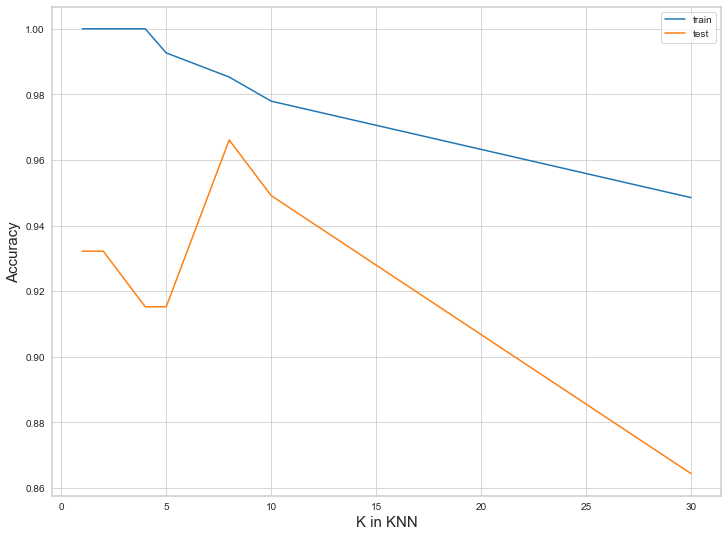

In [97]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("Accuracy");

На самом деле, это не самый лучший способ подбирать гиперпараметры, но способы получше мы рассмотрим в следующий раз, а пока что выберите оптимальное значение k, сделайте предсказания и посмотрите, насколько хорошо ваша модель предсказывает каждый из классов.

30 25 3 1
70 64 1 1
30 24 4 1
70 64 1 1
30 27 1 1
70 64 1 1
30 26 2 1
70 63 2 1
30 26 2 1
70 63 2 1
30 25 3 1
70 64 1 1
30 24 4 1
70 64 1 1
30 27 1 1
70 64 1 1
30 26 2 1
70 63 2 1
30 26 2 1
70 63 2 1


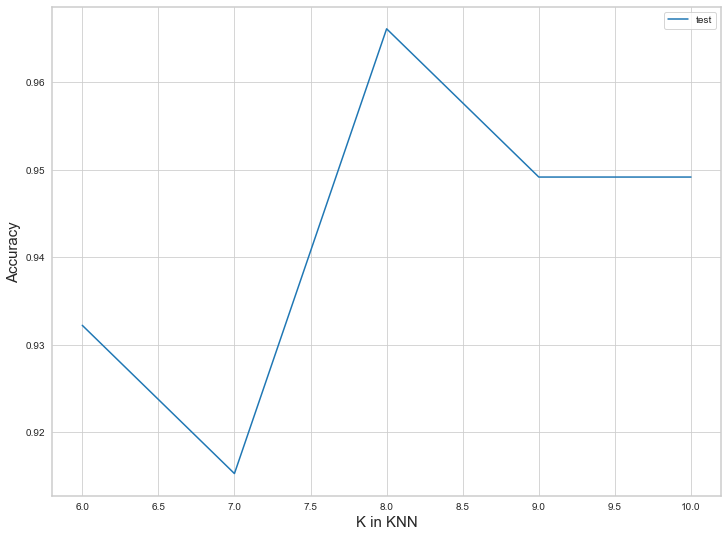

In [122]:
params = [6, 7, 8, 9, 10]
find_best_k(x_train01, y_train01, x_test01, y_test01, params, 'accuracy')
train_metrics, test_metrics = find_best_k(x_train01, y_train01, x_test01, y_test01, params, 'accuracy')
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("Accuracy");

Пока что лучший k = 8

In [99]:
knn_classifier = KNNClassifier(k=8)
knn_classifier.fit(x_train01, y_train01)
prediction = knn_classifier.predict(x_test01)
metrics_binary = binary_classification_metrics(prediction, y_test01)
print (metrics_binary)

30 27 1 1
{'precision': 0.967741935483871, 'recall': 0.967741935483871, 'accuracy': 0.9661016949152542, 'f1 ': 0.967741935483871}


In [ ]:
Для модели с k = 8 и двумя классами показания достаточно хорошие. 

### 1.5. Многоклассоввая классификация (2 балла)

(Это я пока не сделала)

Теперь нужно научиться предсказывать все 10 классов. Для этого в начале напишем соответствующий метод у нашего классификатора.

In [ ]:
# TODO: predict_labels_multiclass in knn.py
# not done
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(X_train, y_train)
predictions = knn_classifier.predict(X_test)

Осталось реализовать метрику качества для многоклассовой классификации, для этого реализуйте функцию `multiclass_accuracy` в `metrics.py`.

In [ ]:
# TODO: multiclass_accuracy in metrics.py
# not done 
multiclass_accuracy(predictions, y_test)

Снова выберите оптимальное значение K как мы делали для бинарной классификации.

## Задание 2. KNN на датасете diabetes (10 баллов)

Теперь попробуем применить KNN к задаче регрессии. Будем работать с [данными](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) о диабете. В этом задании будем использовать класс `KNeighborsRegressor` из библиотеки `sklearn`. Загрузим необходимые библиотеки:

In [28]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [113]:
X, y = load_diabetes(as_frame=True, return_X_y=True)

In [30]:
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


### 2.1. EDA (2 обязательных балла + 2 доп. балла за Pipeline)

Сделайте EDA, предобработайте данные так, как считаете нужным, нужна ли в данном случае стандартизация и почему? Не забудьте, что если вы стандартизуете данные, то нужно считать среднее и сдандартное отклонение на тренировочной части и с помощью них трансформировать и train, и test (**если не поняли это предложение, то обязательно разберитесь**).

**Дополнительно**:
Попробуйте разобраться с [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), чтобы можно было создать класс, который сразу проводит стандартизацию и обучает модель (или делает предсказание). Пайплайны очень удобны, когда нужно применять различные методы предобработки данных (в том числе и к разным столбцам), а также они позволяют правильно интегрировать предобработку данных в различные классы для поиска наилучших гиперпараметров модели (например, `GridSearchCV`).

In [123]:
print(load_diabetes(return_X_y=False, as_frame=False).DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, T-Cells (a type of white blood cells)
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, thyroid stimulating hormone
      - s5      ltg, lamotrigine
      - s6      glu, blood sugar level

Note: Each of these 10 feature va

In [124]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
dtypes: float64(10)
memory usage: 34.7 KB


In [120]:
X['sex'].value_counts()

-0.044642    235
 0.050680    207
Name: sex, dtype: int64

In [121]:
X.describe().round(5)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,442.00000,442.00000,442.00000,442.00000,442.00000,442.00000,442.00000,442.00000,442.00000,442.00000
mean,-0.00000,0.00000,-0.00000,0.00000,-0.00000,0.00000,-0.00000,0.00000,-0.00000,-0.00000
std,0.04762,0.04762,0.04762,0.04762,0.04762,0.04762,0.04762,0.04762,0.04762,0.04762
min,-0.10723,-0.04464,-0.09028,-0.11240,-0.12678,-0.11561,-0.10231,-0.07639,-0.12610,-0.13777
25%,-0.03730,-0.04464,-0.03423,-0.03666,-0.03425,-0.03036,-0.03512,-0.03949,-0.03325,-0.03318
50%,0.00538,-0.04464,-0.00728,-0.00567,-0.00432,-0.00382,-0.00658,-0.00259,-0.00195,-0.00108
75%,0.03808,0.05068,0.03125,0.03564,0.02836,0.02984,0.02931,0.03431,0.03243,0.02792
max,0.11073,0.05068,0.17056,0.13204,0.15391,0.19879,0.18118,0.18523,0.13360,0.13561


Все столбцы - числовые, пропущенных значений нет. Мужчин и женщин примерно поровну (235 и 207). 

Во всех колонках одинаковое среднее и стандартное отклонение - значит, наверное, можно не стандартизовать данные. Также в описании данных написано " Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1)."

Однако в таком случае в тренировочной выборке будет содержаться какая-то инфа о тестовой выборке? Ведь получается, что датасет был стандартизован до нас? 

In [104]:
from sklearn.pipeline import Pipeline

### 2.2. Регрессионная модель (1 балл)

Создайте модель `KNeighborsRegressor`, обучите ее на треноровочных данных и сделайте предсказания.

In [129]:
# split the data into train and test 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(x_train, y_train)
neigh.predict(x_test)

array([244. , 110.5, 177. , 125.5, 243. , 155.5, 270. , 187. , 176. ,
        78. ,  86.5, 111.5,  64. , 279.5, 110.5, 146.5, 262. , 167. ,
       185.5, 142. , 140.5, 110. , 224.5, 269. ,  64. , 264. , 201.5,
       129.5, 194. , 164.5, 133. , 223. , 135. , 275. , 262. ,  63.5,
       172. , 109. ,  90. , 177.5, 120.5, 100. , 266.5, 275. ,  47.5,
        70. , 241.5,  68. , 186. , 202. , 203. ,  78.5, 168.5, 169. ,
       103. ,  73. , 136.5, 102. , 151.5, 185.5, 186. , 219. , 205. ,
       142.5, 139.5, 143. ,  77. , 150.5, 275.5,  71.5, 166. ,  60.5,
       130.5,  79. ,  50.5,  92.5, 153.5, 107. ,  94.5, 227.5, 122.5,
       101.5, 277.5, 173.5, 142. ,  87.5, 127. , 184. , 137. ,  85. ,
       172. , 133. , 191. , 244. , 127. , 252. , 227.5, 170.5, 136. ,
        92.5, 103.5, 302.5, 177.5, 165.5, 180. ,  90.5, 180. , 244. ,
        98. , 163.5,  89.5,  53.5, 154.5, 141.5, 164.5,  66. , 167.5,
       171. , 152.5,  58.5, 175.5,  90. , 306. ,  99.5,  95. ,  91.5,
        87.5, 127. ,

### 2.3. Метрики регресии (3 балла)

Реализуйте метрики $R^2$, MSE и  MAE в `metrics.py`. Примените их для оценки качества полученной модели. Все ли хорошо?

Напомню, что:

$R^2 = 1 - \frac{\sum_i^n{(y_i - \hat{y_i})^2}}{\sum_i^n{(y_i - \overline{y})^2}}$

$MSE = \frac{1}{n}\sum_i^n{(y_i - \hat{y_i})^2}$

$MAE = \frac{1}{n}\sum_i^n{|y_i - \hat{y_i}|}$

In [ ]:
# TODO: r_squared, mse, mae in metrics.py

# not done yet 

### 2.4. Подбор оптимального числа соседей (2 балла)

Мы почти дошли до конца. Теперь осталось при помощи реализованных нами метрик выбрать лучшее количество соседей для нашей модели.

!!! Обратите внимание на то, что значат наши метрики, для некоторых хорошо, когда они уменьшаются, для других наоборот.

In [ ]:
from metrics import r_squared, mse, mae

Для поиска лучшего k вы можете воспользоваться функцией `find_best_k`, которую вы реализовали выше.

### 3. Социализация (0.5 доп. балла)

Так как у нас теперь большая группа, то было бы здорово всем познакомиться получше (так как выпускной не за горами). Соберитесь с одногруппниками в зуме (желательно, чтобы были люди и с Онлайна, и с Питера), познакомьтесь, а сюда прикрепите скриншот с камерами всех участников.

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**

Очень тяжело с нуля разбираться с заданием (на лекции не было никаких примеров кода, с нампаем рука набита не у всех, когда пишешь код в файле и снова загружаешь класс, он не перегружается (и я убила на это часа два, выискивая ошибку), описание данных вроде есть, но на самом деле его нужно гуглить. Как-то очень тяжко для начала, в особенности когда настроили на 3 часа. Я делала домашку со среды, и всё равно сделала меньше половины. Это, конечно, говорит о моём уровне сообразительности, но если честно, очень обидно и есть ощущение "лучше б я забила и по итогу хоть отдохнула нормально". 

Получается немного лента анонимного нытья, а не продуктивное предложение, но как есть :( 
